
# 📄 Project Documentation: Active Learning for Named Entity Recognition (NER)

### Project Objective:
This project implements an **Active Learning** approach to improve **Named Entity Recognition (NER)** using the **spaCy** library.
The goal is to enhance NER performance on a custom dataset with iterative model training, annotation, and evaluation.

### Dataset:
- The dataset consists of text data with named entities labeled for training and testing purposes.
- Active learning iteratively refines the model by selecting uncertain examples for further annotation.

### Tools & Libraries:
- **Python**
- **spaCy** (NLP processing)
- **matplotlib** & **seaborn** (visualizations)
- **NumPy** (numerical operations)

### Workflow:
1. Load and preprocess the dataset.
2. Train the initial NER model.
3. Apply Active Learning to iteratively improve annotations.
4. Evaluate the model using metrics: Precision, Recall, F1 Score, and Accuracy.
5. Visualize the Confusion Matrix from evaluation results.

---


In [5]:
# Import necessary libraries and modules
import spacy
from spacy.training import Example
import pandas as pd
import random
import re
from spacy import logger
from spacy import displacy

In [6]:
# warnings module is used to suppress warnings
# for a cleaner output during training and evaluation
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Loading the datasets :-
training_file = 'training.txt'
development_file = 'development.txt'
testing_file  = 'test.txt'

# Reading the contents of each dataset and storing them
with open(training_file, 'r') as train_file:
    train_data = train_file.read()
with open(development_file, 'r') as dev_file:
    dev_data = dev_file.read()
with open(testing_file, 'r') as test_file:
    test_data = test_file.read()

# Split the dataset into individual records
# and store them in resp lists
train=[]
for line in train_data.split("\n\n"):
  train.append(line)
dev=[]
for line in dev_data.split("\n\n"):
  dev.append(line)
test=[]
for line in test_data.split("\n\n"):
  test.append(line)

In [8]:
# Using regular expresion iterate through the list elements
# for title and article and store in train_article...
try:
  def article_extractor(text):
    article = re.findall(r'a\|(.*)\n' , text)
    return article[0]
  def title_extractor(text):
    title = re.findall(r't\|(.*)\n' , text)
    return title[0]
except Exception as e:
  pass

# Extract titles and abstracts for each dataset
train_article  = []
try:
  for x in train:
    train_article.append(title_extractor(x)+' '+article_extractor(x))
except Exception as e:
  pass
dev_article  = []
try:
  for x in dev:
    dev_article.append(title_extractor(x)+' '+article_extractor(x))
except Exception as e:
  pass
test_article  = []
try:
  for x in test:
    test_article.append(title_extractor(x)+' '+article_extractor(x))
except Exception as e:
  pass

In [9]:
# Again using regular exp finding the entities(start,end,label)
# through the list and storing them in train_labels...
try:
  def get_labels(text):
    l  = re.findall(r'\t(.*)' , text)
    l = [x.split('\t') for x in l]
    labels  = []
    for i in l:
      try:
        labels.append((int(i[0]) , int(i[1]) , i[3]))
      except Exception as e:
        pass
    return labels
  # def get_labels_and_entity(text):
  #   l = re.findall(r'\t(.*)' , text)
  #   l = [x.split('\t') for x in l]
  #   labels  = []
  #   for i in l:
  #     try:
  #       labels.append((int(i[0]) , int(i[1]) , i[3], i[2]))
  #     except Exception as e:
  #       pass
  #   return labels
except Exception as e:
  pass

#Extract labels for each dataset
train__labels  = [get_labels(x) for x in train]
dev__labels = [get_labels(x) for x in dev]
test__labels = [get_labels(x) for x in test]

# Prepare the final labels format for spaCy
train_labels = [{"entities": entry} for entry in train__labels]
dev_labels = [{"entities": entry} for entry in dev__labels]
test_labels = [{"entities": entry} for entry in test__labels]

In [10]:
# Storing the articles and labels in dataframes
train_df  = pd.DataFrame(train_article, columns=['article'])
dev_df  = pd.DataFrame(dev_article, columns=['article'])
test_df  = pd.DataFrame(test_article, columns=['article'])

# Ensuring minimum length across the datsets so they are of same size
min_length = min(len(test_df), len(test_labels), len(train_df), len(train_labels))

# DataFrames truncated to the minimum length
test_df = test_df.iloc[:min_length].copy()
dev_df = test_df.iloc[:min_length].copy()
train_df = train_df.iloc[:min_length].copy()

# Adding labels to the dataframes
test_df['labels'] = test_labels[:min_length]
dev_df['labels'] = dev_labels[:min_length]
train_df['labels'] = train_labels[:min_length]
# print(test_df.head())
# print(dev_df.head())
# Train the NER model
# print(train_df.head())

In [11]:
train_data  = []
dev_data  = []
test_data = []

# Final train,dev,test data in required
# format and storing them in different lists
for _, row in train_df.iterrows():
    text = row['article']
    entities = row['labels']['entities']
    train_data.append((text, {"entities": entities}))

for _, row in dev_df.iterrows():
    text = row['article']
    entities = row['labels']['entities']
    dev_data.append((text, {"entities": entities}))

for _, row in test_df.iterrows():
    text = row['article']
    entities = row['labels']['entities']
    test_data.append((text, {"entities": entities}))

In [12]:
# Intializing a blank spaCy model
nlp = spacy.blank("en")
# Adding the ner pipeline to the model
ner = nlp.add_pipe("ner")


def train_ner(nlp, train_data, iterations=5):
    optimizer = nlp.begin_training()
    for epoch in range(iterations):
        random.shuffle(train_data)
        losses = {}
        for text, annotations in train_data:
            example = Example.from_dict(nlp.make_doc(text), annotations)
            nlp.update([example], drop=0.3, losses=losses)
        print(f"Epoch {epoch+1}/{iterations}, Loss: {losses}")

In [13]:
# Train the NER Model first on dev dataset
train_ner(nlp, dev_data)

Epoch 1/5, Loss: {'ner': np.float32(2232.143)}
Epoch 2/5, Loss: {'ner': np.float32(518.1075)}
Epoch 3/5, Loss: {'ner': np.float32(771.5927)}
Epoch 4/5, Loss: {'ner': np.float32(532.49304)}
Epoch 5/5, Loss: {'ner': np.float32(566.748)}


In [14]:
# And then finally on the training dataset
train_ner(nlp, train_data)

Epoch 1/5, Loss: {'ner': np.float32(14657.083)}
Epoch 2/5, Loss: {'ner': np.float32(7695.428)}
Epoch 3/5, Loss: {'ner': np.float32(5565.563)}
Epoch 4/5, Loss: {'ner': np.float32(4421.047)}
Epoch 5/5, Loss: {'ner': np.float32(3734.6702)}


In [ ]:
# A Function to find uncertain predictions based on conf threshold
# def get_uncertain_predictions(nlp, texts, threshold=0.5):
#     uncertain_samples = []
#     for text in texts:
#         doc = nlp(text)
#         for ent in doc.ents:
#             # Simulate uncertainty based on entity length (longer names -> more confidence)
#             confidence = len(ent.text) / len(text)
#             if confidence < threshold:
#                 uncertain_samples.append((text, ent.text, ent.label_, confidence))
#     return uncertain_samples



def get_uncertain_predictions(nlp, texts, train_data, threshold=0.5):
    uncertain_samples = []
    
    for text in texts:
        doc = nlp(text)
        
        for ent in doc.ents:
            confidence = len(ent.text) / len(text)
            
            if confidence < threshold:
                print(f"\n Uncertain Entity Found:")
                print(f"   - Text: {text}")
                print(f"   - Extracted Entity: '{ent.text}' (Label: {ent.label_})")
                print(f"   - Confidence: {confidence:.2f} (Threshold: {threshold})")

                user_input = input(f" Is '{ent.text}' a correct '{ent.label_}'? (y/n/edit): ").strip().lower()

                if user_input == "y":
                    print("Entity confirmed.")
                elif user_input == "n":
                    print("Removing incorrect entity.")
                    continue
                elif user_input == "edit":
                    new_entity = input("Enter the correct entity text: ").strip()
                    new_label = input("Enter the correct label: ").strip()
                    print(f"Updating entity to '{new_entity}' with label '{new_label}'")
                    ent = (text.index(new_entity), text.index(new_entity) + len(new_entity), new_label)
                else:
                    print("Invalid input, skipping correction.")

                train_data.append((text, {"entities": [(text.index(ent.text), text.index(ent.text) + len(ent.text), ent.label_)]}))
                uncertain_samples.append((text, ent.text, ent.label_, confidence))
    
    if uncertain_samples:
        print("\n Retraining the model with human-corrected labels...")
        train_ner(nlp, train_data, iterations=3)
        print(" Model retrained successfully!")

    return uncertain_samples


UNLABELED_DATA = [
    "Ibuprofen is a headache reliever.",
    "Clonidine is used for blood pressure control.",
    "Patients with diabetes should monitor sugar levels.",
]

uncertain_samples = get_uncertain_predictions(nlp, UNLABELED_DATA, train_data)



 Uncertain Entity Found:
   - Text: Ibuprofen is a headache reliever.
   - Extracted Entity: 'headache' (Label: Disease)
   - Confidence: 0.24 (Threshold: 0.5)
Entity confirmed.

 Uncertain Entity Found:
   - Text: Clonidine is used for blood pressure control.
   - Extracted Entity: 'Clonidine' (Label: Chemical)
   - Confidence: 0.20 (Threshold: 0.5)
Entity confirmed.

 Uncertain Entity Found:
   - Text: Patients with diabetes should monitor sugar levels.
   - Extracted Entity: 'diabetes' (Label: Disease)
   - Confidence: 0.16 (Threshold: 0.5)
Entity confirmed.

 Retraining the model with human-corrected labels...
Epoch 1/3, Loss: {'ner': np.float32(14003.068)}
Epoch 2/3, Loss: {'ner': np.float32(7757.8843)}
Epoch 3/3, Loss: {'ner': np.float32(5676.2046)}
 Model retrained successfully!


In [16]:
# Visualizing the Model
# Model Testing : setting the data using displacy ::
colors  = {
    "Disease" : "#ff698f",
    "Chemical" : "#1472ff"
}

options  = {"ents" : ["Disease" , "Chemical"] , "colors" : colors}

In [17]:
# Saving the Model to the working directory
def save_model(nlp, model_path):
    nlp.to_disk(model_path)
    print(f"Model saved to {model_path}")

save_model(nlp=nlp , model_path="saved_model")

Model saved to saved_model


In [18]:
# Loading the saved NER Model
nlp = spacy.load('saved_model')

# Testing NER on unseen data(just first 3 docs)
for i in range(3):

    
    text = test_data[i][0]
    doc  = nlp(text=text)
    spacy.displacy.render(doc ,style  = "ent" , jupyter = True  , options = options)


In [19]:
# Evaluate the NER model
def evaluate_ner(nlp, test_data):
    global TP, FP, FN, TN         # making them global for conf matrix
    TP, FP, FN, TN = 0, 0, 0, 0
    for text, annotations in test_data:
        doc = nlp(text)           # Process the text with trained model
        # Extract the predicted entities as a set of (start,end,label) tuples
        predicted = set([(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])
        # Extract actual entities as a set of (start,end,label) tuples
        truths = set(annotations["entities"])

        TP += len(predicted & truths)  # Correctly identified entities
        FP += len(predicted - truths)  # Incorrectly identified entities
        FN += len(truths - predicted)  # Missed entities

        total_words = len(text.split())                 # Approximate number of words in text
        num_true_nonreq = total_words - len(truths)     # Words that are not labeled as entities in ground truth
        num_pred_nonreq = total_words - len(predicted)  # Words that are not labeled as entities by model
        TN += min(num_true_nonreq, num_pred_nonreq)     # Correctly ignored non-entities

    # Calculate Performance Metrics
    precision = TP / (TP + FP) if (TP + FP) else 0 # Precision = TP / (TP + FP)
    recall = TP / (TP + FN) if (TP + FN) else 0    # Recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    # Accuracy calculation
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0

    # Print Evaluation metrics
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Negatives (TN): {TN}")
    print(f"\nPrecision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")
    print(f"\nAccuracy: {accuracy:.2%}")

# Evaluate the NER model
evaluate_ner(nlp,test_data)

True Positives (TP): 6291
False Positives (FP): 1197
False Negatives (FN): 3518
True Negatives (TN): 86591

Precision: 84.01%
Recall: 64.13%
F1 Score: 72.74%

Accuracy: 95.17%


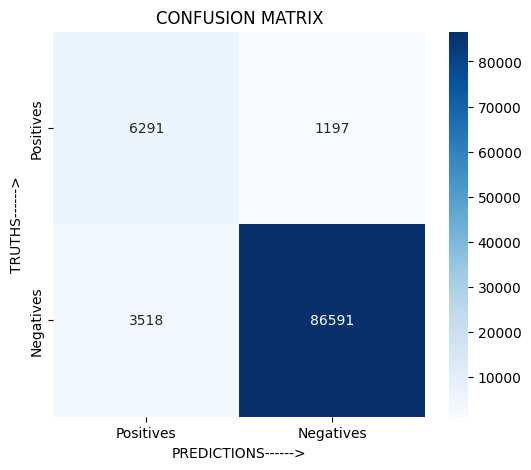

In [20]:
# Plotting the Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# a numpy array to store the confusion matrix
conf_matrix = np.array([[TP, FP],
                        [FN, TN]])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positives', 'Negatives'],
            yticklabels=['Positives', 'Negatives'])
plt.title('CONFUSION MATRIX')
plt.xlabel('PREDICTIONS------>')
plt.ylabel('TRUTHS------>')
plt.show()
